Delete all variables in the current environment (if you have already run some cells) - clean state.

In [22]:
%reset

Import all necessary packages.

In [23]:
import os
import shutil
import json
from dateutil import parser
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import networkx as nx

Replace with the path to the root folder of the project.

In [24]:
rootdir_path = '/home/andreistoica12/research-internship'

Replace with the path to the folder where we store the dataset.

In [25]:
data_path = '/home/andreistoica12/research-internship/data/PhemeDataset'

IMPORTANT NOTE: After running the code, some files from the dataset will be different from the original versions, i.e. the "retweets.json" files inside each story folder were initially invalid. In order to consider and process the retweets in the longitudinal analysis, I formatted these files so that they are valid, parsable JSON files. If the file contained only one retweet object, it has not been modified. If the file contained multiple retweets, the file now contains a list of retweet objects, separated by a comma, as per the JSON syntax.

The paths to the folder containing all subfolders corresponding to each event of major interest (the Charlie Hebdo shooting, footballer Essien having Ebola, etc.). Tweets here are all written in English.

In [26]:
events_path = data_path + "/threads/en"

Create 2 subfolders to store important files and graphs, respectively. If they already existed (from previous runnings of the project), delete the folders and their contents and create empty folders to store the current files and graphs, relevant to the current state of the project.

In [27]:
files_path = os.path.join(rootdir_path, 'files')
if os.path.exists(files_path):
   shutil.rmtree(files_path, ignore_errors=False, onerror=None)
os.makedirs(files_path)

graphs_path = os.path.join(rootdir_path, 'graphs')
if os.path.exists(graphs_path):
   shutil.rmtree(graphs_path, ignore_errors=False, onerror=None)
os.makedirs(graphs_path)

In [28]:
pheme_graphs_path = os.path.join(graphs_path, 'pheme')
if os.path.exists(pheme_graphs_path):
   shutil.rmtree(pheme_graphs_path, ignore_errors=False, onerror=None)
os.makedirs(pheme_graphs_path)

In [29]:
pheme_longitudinal_analysis_graphs = os.path.join(pheme_graphs_path, 'longitudinal-analysis')
if os.path.exists(pheme_longitudinal_analysis_graphs):
   shutil.rmtree(pheme_longitudinal_analysis_graphs, ignore_errors=False, onerror=None)
os.makedirs(pheme_longitudinal_analysis_graphs)

In [30]:
pheme_reaction_times_graphs = os.path.join(pheme_graphs_path, 'reaction-times')
if os.path.exists(pheme_reaction_times_graphs):
   shutil.rmtree(pheme_reaction_times_graphs, ignore_errors=False, onerror=None)
os.makedirs(pheme_reaction_times_graphs)

In [31]:
pheme_reaction_counts_graphs = os.path.join(pheme_graphs_path, 'reaction-counts')
if os.path.exists(pheme_reaction_counts_graphs):
   shutil.rmtree(pheme_reaction_counts_graphs, ignore_errors=False, onerror=None)
os.makedirs(pheme_reaction_counts_graphs)

Here, I define a function that first reads the JSON file and stores it into a dictionary, then parses the date contained at the "created_at" key. The number returned is an integer. 

In [32]:
def tweet_hour(tweet_path):
    """Function that parses a JSON file associated with a tweet in the PhemeDataset and returns the posting hour.

    Args:
        tweet_path (str): path to the JSON file associated with a tweet

    Returns:
        int: posting hour of a tweet
    """    
    with open(tweet_path) as f:
        tweet = json.load(f)
    date = parser.parse(tweet['created_at'])
    
    return date.hour

Function to return the source path, given the story path.

In [33]:
def source_tweet_path(story_path):
    """Function that, given the path to a story, gets the path to the JSON file corresponding to the source tweet

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        str: path to the source tweet JSON file
    """    
    source_dir_path = story_path + "/source-tweets"
    source_path = source_dir_path + "/" + os.listdir(source_dir_path)[0]
    
    return source_path

Function to return a list of all reactions' paths.

In [34]:
def reaction_tweets_paths(story_path):
    """Function that generates a list of reactions (replies) to a tweet within a story.

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        list: list of paths(strings) for the reactions to the source tweet of a story
    """    
    reactions_paths_list = []
    reactions_dir_path = story_path + "/reactions"
    for reaction_name in os.listdir(reactions_dir_path):
        reaction_path = reactions_dir_path + "/" + reaction_name
        reactions_paths_list.append(reaction_path)
        
    return reactions_paths_list

Function to validate whether a given JSON file is valid or not. Unmodified retweets files (the ones from teh original dataset) are not valid. We only want ot modify them when they are invalid, otherwise they will become invalid again, as we will have duplicate characters ("[[" / "]]" / ",,") .

In [35]:
def validateJSON(JSON_path):
    try:
        with open(JSON_path, 'r') as file:
            data = json.load(file)
    except ValueError as err:
        return False
    return True

Function to modify/format invalid JSON files for further processing.

In [36]:
def format_retweets_json(retweets_path):
    if not validateJSON(retweets_path):
        with open(retweets_path, 'r') as invalid_json:
            data = invalid_json.read()
        data = "[\n" + data.replace("}\n{", "},\n{") + "]"
        with open(retweets_path,'w') as valid_json:
            valid_json.write(data)

Function to return a list of the hours when all retweets of a specific story have been posted.

In [37]:
def hours_list_retweets(story_path):
    retweets_path = story_path + "/retweets.json"
    hours = []
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            hours = [ parser.parse(retweet['created_at']).hour for retweet in retweets_list ]
        else:   # we have this case when the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            hours = [parser.parse(retweets_list['created_at']).hour]

    return hours

I define a function to store all occurences of dates (only the hours) in a list.

In [38]:
def hours_list_story(story_path):
    # I create a list with all occurences of dates corresponding to the source tweet, reactions (replies) and retweets.
    hours = []

    # source hour
    source_path = source_tweet_path(story_path)
    hour = tweet_hour(source_path)
    hours.append(hour)

    # reactions hours
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        hour = tweet_hour(reaction_path)
        hours.append(hour)
    
    # retweets hours
    hours.extend(hours_list_retweets(story_path))
    
    return hours

Here, I define a function to return a pandas Series, representing the distribution of the hours of tweets (source tweets, reactions and retweets) posted regarding a specific event given as an input parameter. I chose to convert the list to a pandas Series due to the ease in creating a distribution and corresponding box plot.

In [39]:
def time_distribution_event(event_path):
    hours = []
    for story_id in os.listdir(event_path):
        story_path = event_path + "/" + story_id
        hours.extend(hours_list_story(story_path))
    hours.sort()
    hours_series = pd.Series(hours)
    distribution = hours_series.value_counts()[hours_series.unique()]
    
    return distribution

The following function is delegated to plot the distribution per hour of the tweets sent about a specific topic/event.

In [40]:
def plot_event_distribution(event_name, distribution):
    axes = distribution.plot(kind='bar')
    figure_path = f"{pheme_longitudinal_analysis_graphs}/{event_name}_distribution.png"
    axes.figure.savefig(figure_path)
    plt.close()

Function to plot and save in the local graphs/ folder the distributions corresponding to all events.

In [41]:
def plot_all_event_distributions(events_path):
    for event in os.listdir(events_path):
        event_path = events_path + "/" + event
        distribution = time_distribution_event(event_path)
        plot_event_distribution(event, distribution)

In [42]:
plot_all_event_distributions(events_path)

Computing the reaction times to tweets

In [43]:
deltas_types = ['hours', 'minutes']

Choose between 'hours' and 'minutes' if you want to plot the final graph in hours or minutes.

NOTE: This variable needs to have either one of the values in the deltas_types list, otherwise the deltas will be an empty list,
so the plots will make no sense in the end.

In [44]:
deltas_type = deltas_types[0]

In [45]:
def deltas_story(story_path, deltas_type):
    """Function that generates a list of time differences between the moment a reaction (reply or retweet) has been posted
    and the moment the source tweet of a story has been posted. Depending on the time unit of such time difference 
    (e.g. 'hours' or 'minutes'), the function outputs a list with numbers expressed in the respective type

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)
        deltas_type (str): time unit for time differences

    Returns:
        list: list of time differences expressed in deltas_type time units
    """    
    if deltas_type not in ['minutes', 'hours']:
        print("Deltas type doesn't have a valid value - it should be either 'hours' or 'minutes' !")
        return []
    
    factor = 60 * 60
    factor = 60 if deltas_type == 'minutes' else factor

    deltas = []

    # Step 1: get t0 datetime object from the source timestamp
    source_path = source_tweet_path(story_path)
    with open(source_path) as file:
        source = json.load(file)
    t0 = parser.parse(source['created_at'])

    # Step 2: for all reactions, get the difference in minutes/hours 
    # from the time the source was posted and the time each reaction was posted
    reactions_paths_list = reaction_tweets_paths(story_path)
    for reaction_path in reactions_paths_list:
        with open(reaction_path) as file:
            reaction = json.load(file)
        deltas.append((parser.parse(reaction['created_at']) - t0).total_seconds() / factor )

    # Step 3: for all retweets, get the same time difference in miuntes as above
    retweets_path = story_path + "/retweets.json"
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        if type(retweets_list) == list:
            deltas.extend([ (parser.parse(retweet['created_at']) - t0).total_seconds() / factor for retweet in retweets_list ])
        else:   # here, the JSON file contains one object, but we need to pass a list forward, so we'll have a 1-length list
            deltas.extend([ (parser.parse(retweets_list['created_at']) - t0).total_seconds() / factor ])

    return deltas

In [46]:
def deltas_event(event_path, deltas_type):
    deltas = []
    for story_name in os.listdir(event_path):
            story_path = event_path + "/" + story_name
            deltas.extend(deltas_story(story_path, deltas_type))

    return deltas

In [47]:
def deltas_all_events(events_path, deltas_type):
    deltas_all_events = {}
    for event_name in os.listdir(events_path):
        event_path = events_path + "/" + event_name
        deltas_all_events[event_name] = deltas_event(event_path, deltas_type)
    
    return deltas_all_events

We need to define the number of clusters we want to have, as it needs to be passed onto the K-Means algorithm. Therefore, one of the easiest methods is to look for the "elbow" point in the plot above, i.e. the point where the rate of decrease in WCSS begins to level off. The optimal number of clusters can be found through teh KneeLocator function within the kneed Python module. Curves with positive concavity are called "elbows", the ones with negative concavity are called "knees". Our K-Means inertia values are decreasing when we increase the number of clusters, because the inertia is calculated by measuring the distance between each data point and its centroid, so having more clusters means points will be closer to their clusters' centroids. So we will have a decreasing convex curve and thus we will pass on this information as arguments in the KneeLocator function.

In [48]:
def elbow_method_k_means_clusters(deltas, max_nr_clusters):
    wcss = []   # within-cluster sum of squares
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)
    for k in range(1, max_nr_clusters+1):
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
        kmeans.fit(deltas)
        wcss.append(kmeans.inertia_)

    kn = KneeLocator(range(1, max_nr_clusters+1), wcss, curve='convex', direction='decreasing')

    # # Plot the within-cluster sum of squares against the number of clusters
    # # If you want to visualize the knee point of the graph, you can plot the graph using the following function, 
    # # specifically designed to highlight the knee point
    # kn.plot_knee()

    return kn.knee

In [49]:
def k_means_clustering(k, deltas):
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(deltas)

    # Get the labels assigned to each data point
    labels = kmeans.labels_

    # Get the centroids of each cluster
    centroids = kmeans.cluster_centers_

    # # Print an overview of the resulting clusters
    # for i in range(k):
    #     cluster_data = deltas[labels == i]
    #     print(f"Cluster {i+1} has {len(cluster_data)} data points and a centroid of {centroids[i][0]}")

    # Create a dictionary to store the clustered data
    clusters_dict = {}
    labels_list = []
    for label in labels:
        labels_list.append(label)
    
    for index, label in enumerate(labels_list):
        if label not in clusters_dict:
            clusters_dict[label] = [deltas[index][0]]
        else:
            clusters_dict[label].append(deltas[index][0])
    
    return clusters_dict

The implementation below makes use of the Nearest Neighbors algorithm in order to find the optimal value for epsilon, as per:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc .
However, the distances plot seems odd and the knee obtained through the KneeLocator function doesn't yield the best results. For now, I set the eps parameter to be 0.3 so that we have good clustering results.

For example, I tried to cluster the deltas from all the stories within the Germanwings crash event.

In [50]:
deltas = deltas_event('/home/andreistoica12/research-internship/data/PhemeDataset/threads/en/prince-toronto', deltas_type)

In [51]:
def epsilon_DBSCAN(deltas):
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    neigh = NearestNeighbors(n_neighbors=5) # usually, the kth nearest neighbor is chosen somewhere between 3 and 10
    nbrs = neigh.fit(deltas)
    distances, indices = nbrs.kneighbors(deltas)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

    kn = KneeLocator(range(1, len(distances)+1), distances, curve='convex', direction='increasing')

    return float(distances[kn.knee])

As you can see, the graph seems odd.

0.13027777777777816

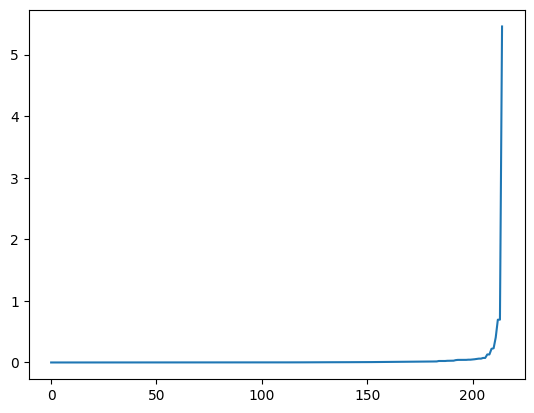

In [52]:
epsilon_DBSCAN(deltas)

In [53]:
def DBSCAN_clustering(deltas):
    deltas = np.array(deltas)
    deltas = deltas.reshape(-1, 1)

    # # Compute the value for epsilon using the function defined previously
    # epsilon = epsilon_DBSCAN(deltas)
    epsilon = 0.3

    # Create a DBSCAN object with epsilon as the computed value and minimum samples=5
    dbscan = DBSCAN(eps=epsilon, min_samples=5)

    # Fit the DBSCAN object to the data
    dbscan.fit(deltas)

    # Get the labels assigned to each data point
    labels = dbscan.labels_

    # # Print the number of clusters and the labels assigned to each data point
    # n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # print("Number of clusters:", n_clusters)
    # print("Labels:", labels)

    # Create a dictionary to store the clusters
    clusters_dict = {}
    for i, label in enumerate(labels):
        if label in clusters_dict:
            clusters_dict[label].append(deltas[i][0])
        else:
            clusters_dict[label] = [deltas[i][0]]
    
    return clusters_dict

Until now, I have implemented 2 ways to cluster the deltas. By default, I use the Density-Based Spatial Clustering of Applications with Noise (DBSCAN), because it focuses on the patterns that we observe from the majority of data points, and the outliers don't affect the way it clusters the other points, whereas the K-Means algorithm builds its centroids based on all the data points and it may be deceiving in a plot. Moreover, plots obtained with the DBSCAN clustering algorithm tend to yield more and tighter clusters than the number of clusters obtained with the help of the Elbow Method in the case of the K-Means clustering.

In [54]:
clustering_algorithms = ['k-means', 'DBSCAN']

In [55]:
clustering_algorithm = clustering_algorithms[1]

In [56]:
def clusters_all_events(events_path, deltas_type, clustering_algorithm):
    all_events_deltas = deltas_all_events(events_path, deltas_type)
    all_events_clusters = {}
    for event_name, event_deltas in all_events_deltas.items():
        if clustering_algorithm == 'k-means':
            # loop over maximum 10 clusters, as this is a range where you usually find the optimum number of clusters
            k = elbow_method_k_means_clusters(event_deltas, 10)
            # print(f"\nEvent {event_name}:")
            # print(f"NOTE: Numbers represent {deltas_type}\n")
            all_events_clusters[event_name] = k_means_clustering(k, event_deltas)
        elif clustering_algorithm == 'DBSCAN':
            all_events_clusters[event_name] = DBSCAN_clustering(event_deltas)
        
    return all_events_clusters


Function that receives the first clusters generated either through K-Means or DBSCAN and tries to see whether it can find some subgraphs more relevant for the visualization. A recursive function is defined in order to re-cluster the biggest cluster until the newly-computed biggest cluster contains fewer than 70% of the data points. I considered this a good threshold to stop, because the graph will clearly show, on one hand, which is the overwhelingly biggest cluster, and on the other hand, the next number_of_clusters - 1 biggest clusters/subclusters so we have a better overview of the most important clusters/subclusters in our datasets. I chose to apply K-Means for the reapplication of clustering on the biggest cluster due to its computationally-efficient nature, which is hands-down superior to DBSCAN's. In fact, not only did the algorithm implemented with DBSCAN for subclusters take a lot longer, it even crashed before the end, due to the number of recursive calls exceeding the limit of the kernel. Therefore, considering the trade-off between better clustering and efficiency, the option below yielded the optimal results.

Besides technical reasons, I opted to first cluster the points with DBSCAN, due to its ability to ignore outlier points, they are not taken into account when clusters are created, which is of great help for a good visualization. After the first clusterization, we only have relevant points, so K-Means will yield good results (its problem were outlier points which influenced the computation of centroids).

In [57]:
def clusters_for_plot(clusters, number_of_clusters):
    total_length = 0
    for value in clusters.values():
            total_length += len(value)
    subclusters_for_plot = {}
    
    def subclusters(clusters):
            if(len(clusters)):
                key_for_biggest_cluster = max(clusters, key=lambda k: len(clusters[k]))
                if len(clusters[key_for_biggest_cluster]) / total_length < 0.7:
                    print("Reached base case.")
                    return clusters
                else:
                    # print("We'll go back into subclusters function.")
                    # print(f"Length of current clusters: {len(clusters)}")
                    # print("Current clusters look like this:")
                    # for key, value in clusters.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")

                    biggest_cluster = clusters[key_for_biggest_cluster]
                    # print("Biggest cluster:")
                    # print(biggest_cluster[:3])
                    
                    del clusters[key_for_biggest_cluster]
                    # print("Clusters after removing biggest_cluster:")
                    # for key, value in clusters.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")
                    
                    # K-MEANS CLUSTERING
                    k = elbow_method_k_means_clusters(biggest_cluster, 10)
                    # print(f"k = {k}")
                    
                    subcl = k_means_clustering(k, biggest_cluster)
                    # print("subcl - the subclusters dictionary obtained from the biggest_cluster looks like this:")
                    # for key, value in subcl.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")
                    
                    for key, value in subcl.items():
                        clusters[max(clusters.keys())+1] = value
                    
                    # print(f"Length of clusters after modifications: {len(clusters)}")
                    # print("Clusters look like this:")
                    # for key, value in clusters.items():
                    #      print(f"{key}: {math.floor(min(value))} - {math.ceil(max(value))}")
                    
                    subclusters(clusters)
            else:
                print("Clusters dictionary is empty.")
                return clusters
            

    subclusters(clusters)

    if len(clusters) >= number_of_clusters:
        for i in range(number_of_clusters):
            key_for_biggest_cluster = max(clusters, key=lambda k: len(clusters[k]))
            subclusters_for_plot[i] = clusters[key_for_biggest_cluster]
            del clusters[key_for_biggest_cluster]
    else:
        subclusters_for_plot = clusters
    
    return subclusters_for_plot

In [58]:
def plot_reaction_times(events_path, deltas_type):
    all_clusters = clusters_all_events(events_path, deltas_type, clustering_algorithm)

    for event_name, clusters in all_clusters.items():
        print(f"Event: {event_name}")
        clusters_to_be_plotted = clusters_for_plot(clusters, 5)

        final_clusters_for_plot = {}
        for key, value in clusters_to_be_plotted.items():
            final_clusters_for_plot[f"{math.floor(min(value))} - {math.ceil(max(value))}"] = len(value)

        intervals_unsorted = list(final_clusters_for_plot.keys())
        values_unsorted = list(final_clusters_for_plot.values())
        df_plot = pd.DataFrame(
            dict(
                Interval=intervals_unsorted,
                Value=values_unsorted
            )
        )
        
        df_plot['Start of interval'] = df_plot['Interval'].str.split(' - ').str[0]
        df_plot['Start of interval'] = df_plot['Start of interval'].apply(pd.to_numeric) 
        df_plot_sorted = df_plot.sort_values('Start of interval')
        intervals = list(df_plot_sorted['Interval'])
        values = list(df_plot_sorted['Value'])


        plt.bar(range(len(final_clusters_for_plot)), values, tick_label=intervals)
        # Rotate the x-axis labels by 45 degrees
        plt.xticks(rotation=45)
        plt.title(f'Distribution of reaction times in {deltas_type}')
        plt.xlabel(f'Reaction times (between x and y {deltas_type})')
        plt.ylabel('Number of reactions')
        plt.savefig(pheme_reaction_times_graphs + f"/{event_name}_reaction_times.png")
        plt.close()

NOTE: the cell below runs for ~22 sec on my machine if the session has just started. If you run the code again, it takes ~18 sec, due to probably cached information.

In [59]:
plot_reaction_times(events_path, deltas_type)

Event: germanwings-crash
Reached base case.
Event: ottawashooting
Reached base case.
Event: ferguson
Reached base case.
Event: sydneysiege
Reached base case.
Event: charliehebdo
Reached base case.
Event: prince-toronto
Reached base case.
Event: ebola-essien
Reached base case.
Event: putinmissing
Reached base case.


In [60]:
# TODO: see how to make K-Means have all uninterfering deltas (if I can even do that)
# (e.g. in cluser 1, centroid 2, there is a delta of 4.4 and in cluster 2, centroid 15, there is a delta of 3.3)

In [61]:
# TODO: document new functions, explain how I sorted the columns in graphs for all events

In [62]:
# TODO: see what DBSCAN does exactly and how it is different than K-Means (we can see sub clusters, we usually have more clusters etc.)

In [63]:
# TODO: explain the function for creating subclusters of the biggest clusters and choosing the most important ones

Reactions counts for the source tweets - the number of reactions per tweet posted at hour x.

In [64]:
def reactions_count_for_source_tweet(story_path):
    """Function that generates the number of reactions (replies or retweets) of a single source tweet 
    (a story contains one source tweet).

    Args:
        story_path (str): path to the root folder of a story (e.g. /your/path/to/charliehebdo/552783667052167168)

    Returns:
        int: number of reactions for a source tweet
    """    
    reactions_paths_list = reaction_tweets_paths(story_path)
    reactions_count = len(reactions_paths_list)

    retweets_path = story_path + "/retweets.json"
    if os.path.exists(retweets_path):
        format_retweets_json(retweets_path)
        with open(retweets_path, 'r') as file:
            retweets_list = json.load(file)
        reactions_count += len(retweets_list)
    
    return reactions_count

In [65]:
def reaction_counts_per_tweet_event(event_path):
    """Function that generates the dictionary of reaction counts per tweet per hour.
     Based on this dictionary, a plot can be made.

    Args:
        event_path (str): path to the root folder of an event (e.g. /your/path/to/charliehebdo)

    Returns:
        dict: dictionary with keys as posting hours of source tweets and values as the number of reactions per tweet per key(hour)
    """    
    number_of_source_tweets_per_hour = {}
    reactions_count_per_hour = {}
    for story_id in os.listdir(event_path):
        story_path = event_path + "/" + story_id
        source_path = source_tweet_path(story_path)
        source_hour = tweet_hour(source_path)
        if source_hour in number_of_source_tweets_per_hour:
            number_of_source_tweets_per_hour[source_hour] += 1
        else:
            number_of_source_tweets_per_hour[source_hour] = 1
        if source_hour in reactions_count_per_hour:
            reactions_count_per_hour[source_hour] += reactions_count_for_source_tweet(story_path)
        else:
            reactions_count_per_hour[source_hour] = reactions_count_for_source_tweet(story_path)

    reactions_per_tweet = {}
    for source_hour in number_of_source_tweets_per_hour:
        reactions_per_tweet[source_hour] = round(reactions_count_per_hour[source_hour] / number_of_source_tweets_per_hour[source_hour])

    return reactions_per_tweet
    # COMMENT THE FIRST RETURN STATEMENT AND UNCOMMENT THE SECOND TO RETURN A LIST WITH 2 DICTIONARIES:
    # - the reaction counts per tweet
    # - the absolute reaction counts
    # return [reactions_per_tweet, reactions_count_per_hour]


In [66]:
# function to add value labels - adds the value of y
def add_labels_y_value(x,y):
    """Function that takes the x and y-axis to be passed onto a plot function and generates labels,
    such that on top of each y value, it is displayed centrally.

    Args:
        x (list): list of labels for x-axis of a plot
        y (list): list of values for y-axis of a plot
    """    
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [67]:
def add_labels_percentage(x, y):
    """Function that takes the x and y-axis to be passed onto a plot function and generates labels,
    such that on top of each y value, the percentage of the y value out of the sum of all y-s is displayed as a red bounding box.
    Useful when y-s represent the counts of occurences for some values.

    Args:
        x (list): list of labels for x-axis of a plot
        y (list): list of values for y-axis of a plot
    """    
    for i in range(len(x)):
        percentage = y[i] / sum(y) * 100
        plt.text(i, y[i], f"{round(percentage, 1)}%", ha = 'center',
                 bbox = dict(facecolor = 'red', alpha =.7, pad=2))

In [68]:
def plot_reaction_counts_per_tweet_event(event_path):
    """Function that creates and saves locally a plot for an event in the dataset. The plots shows the number of reaction counts
    (replies or retweets) per tweet posted at an hour indicated by the x-axis labels.

    Args:
        event_path (str): path to the root folder of an event (e.g. /your/path/to/charliehebdo)
    """    
    reactions_per_tweet_dict = reaction_counts_per_tweet_event(event_path)

    # sort the dictionary by keys
    sorted_reactions_per_tweet_dict = sorted(reactions_per_tweet_dict.items())

    # extract the sorted keys and values
    sorted_posting_hours = [k for k, v in sorted_reactions_per_tweet_dict]
    sorted_counts = [v for k, v in sorted_reactions_per_tweet_dict]

    plt.bar(range(len(reactions_per_tweet_dict)), sorted_counts, tick_label=sorted_posting_hours)
    # Rotate the x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    # calling the function to add value labels
    add_labels_y_value(sorted_posting_hours, sorted_counts)
    graph_type = 'per tweet'
    plt.title(f"Reaction counts {graph_type} - {os.path.basename(event_path)} event")
    plt.xlabel("Posting hour of source tweet")
    plt.ylabel(f"Number of reactions {graph_type}")
    plt.savefig(pheme_reaction_counts_graphs + f"/{os.path.basename(event_path)}_reaction_counts_{graph_type}.png")
    plt.close()

    # COMMENT THE FIRST PART OF THE FUNCTION AND UNCOMMENT THIS PART TO CREATE 2 GRAPHS:
    # - reaction counts per tweet per hour
    # - absolute reaction counts per hour
    # NOTE: you should also return a list in the reaction_counts_per_tweet_event() function 
    # (comment out the current return statement and uncomment the other)
    
    # [reactions_per_tweet_dict, reactions_count_per_hour_dict] = reactions_per_tweet_event(event_path)
    # results = [reactions_per_tweet_dict, reactions_count_per_hour_dict]
    # for i in range(len(results)):
    #     dictionary = results[i]
    #     # sort the dictionary by keys
    #     sorted_reactions_per_tweet_dict = sorted(dictionary.items())

    #     # extract the sorted keys and values
    #     sorted_posting_hours = [k for k, v in sorted_reactions_per_tweet_dict]
    #     sorted_counts = [v for k, v in sorted_reactions_per_tweet_dict]

    #     plt.bar(range(len(reactions_per_tweet_dict)), sorted_counts, tick_label=sorted_posting_hours)
    #     # Rotate the x-axis labels by 45 degrees
    #     plt.xticks(rotation=45)
    #     # calling the function to add value labels
    #     add_labels_y_value(sorted_posting_hours, sorted_counts)
    #     graph_type = 'absolute'
    #     graph_type = 'per tweet' if i == 0 else graph_type
    #     plt.title(f"Reaction counts {graph_type} - {os.path.basename(event_path)} event")
    #     plt.xlabel("Posting hour of source tweet")
    #     plt.ylabel(f"Number of reactions {graph_type}")
    #     plt.savefig(pheme_reaction_counts_graphs + f"/{os.path.basename(event_path)}_reaction_counts_{graph_type}.png")
    #     plt.close()

In [69]:
def plot_reaction_counts_per_tweet_all_events(events_path):
    """Function that saves all plots, corresponding to all events, locally.

    Args:
        events_path (str): path to the root folder of all events in the dataset(e.g. /your/path/to/threads/en)
    """    
    for event_name in os.listdir(events_path):
        event_path = events_path + "/" + event_name
        plot_reaction_counts_per_tweet_event(event_path)

In [70]:
plot_reaction_counts_per_tweet_all_events(events_path)